In [1]:
import xarray as xr
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
import rasterio
from rasterio.crs import CRS
import os
from dask.distributed import Client, LocalCluster
from datetime import datetime,timedelta
import glob
import indices_function as ifun
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import geopandas as gpd
warnings.filterwarnings('ignore')

In [3]:
!rm ./plot/*

In [2]:
cluster = LocalCluster(
    n_workers=10, 
    threads_per_worker=1,
    timeout='3600s',
    memory_limit='5GB',
)
client = Client(cluster)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:46197/status,
Dashboard: http://127.0.0.1:46197/status,Workers: 10
Total threads: 10,Total memory: 46.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46235,Workers: 10
Dashboard: http://127.0.0.1:46197/status,Total threads: 10
Started: Just now,Total memory: 46.57 GiB
Comm: tcp://127.0.0.1:38247,Total threads: 1
Dashboard: http://127.0.0.1:40265/status,Memory: 4.66 GiB
Nanny: tcp://127.0.0.1:44103,


In [22]:
# Define intervals with non-linear spacing
intervals = [0, 0.2, 0.4, 0.6, 0.8, 1, 2, 4, 6, 8, 10, 12, 14]

# Select 20 colors from YlGn colormap
colors = plt.cm.YlGn(np.linspace(0, 1, 13))

# Create a custom colormap with specified intervals and colors
cmap= mcolors.ListedColormap(colors)
bounds = mcolors.BoundaryNorm(intervals, cmap.N)


In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define color intervals and corresponding colors
intervals_diff= np.arange(-1, 1.1, 0.1)
colors_diff= plt.cm.PuOr_r(np.linspace(0, 1, len(intervals_diff) - 1))  # Use YlOrRd colormap

# Create a custom colormap with specified intervals and colors
cmap_diff= mcolors.ListedColormap(colors_diff)
bounds_diff= mcolors.BoundaryNorm(intervals_diff, cmap_diff.N)



/nobackupp10/datapool/NEX-DCP30-CMIP6/ACCESS-CM2
/nobackupp10/datapool/NEX-DCP30-CMIP6/ACCESS-ESM1-5
/nobackupp10/datapool/NEX-DCP30-CMIP6/BCC-CSM2-MR
/nobackupp10/datapool/NEX-DCP30-CMIP6/CMCC-ESM2
/nobackupp10/datapool/NEX-DCP30-CMIP6/CNRM-CM6-1
/nobackupp10/datapool/NEX-DCP30-CMIP6/CNRM-ESM2-1
/nobackupp10/datapool/NEX-DCP30-CMIP6/CanESM5
/nobackupp10/datapool/NEX-DCP30-CMIP6/EC-Earth3
/nobackupp10/datapool/NEX-DCP30-CMIP6/EC-Earth3-Veg-LR
/nobackupp10/datapool/NEX-DCP30-CMIP6/FGOALS-g3
/nobackupp10/datapool/NEX-DCP30-CMIP6/GFDL-CM4
/nobackupp10/datapool/NEX-DCP30-CMIP6/GFDL-ESM4
/nobackupp10/datapool/NEX-DCP30-CMIP6/GISS-E2-1-G
/nobackupp10/datapool/NEX-DCP30-CMIP6/HadGEM3-GC31-LL
/nobackupp10/datapool/NEX-DCP30-CMIP6/HadGEM3-GC31-MM
/nobackupp10/datapool/NEX-DCP30-CMIP6/INM-CM4-8
/nobackupp10/datapool/NEX-DCP30-CMIP6/INM-CM5-0
/nobackupp10/datapool/NEX-DCP30-CMIP6/IPSL-CM6A-LR
/nobackupp10/datapool/NEX-DCP30-CMIP6/KACE-1-0-G
/nobackupp10/datapool/NEX-DCP30-CMIP6/KIOST-ESM
/nobacku

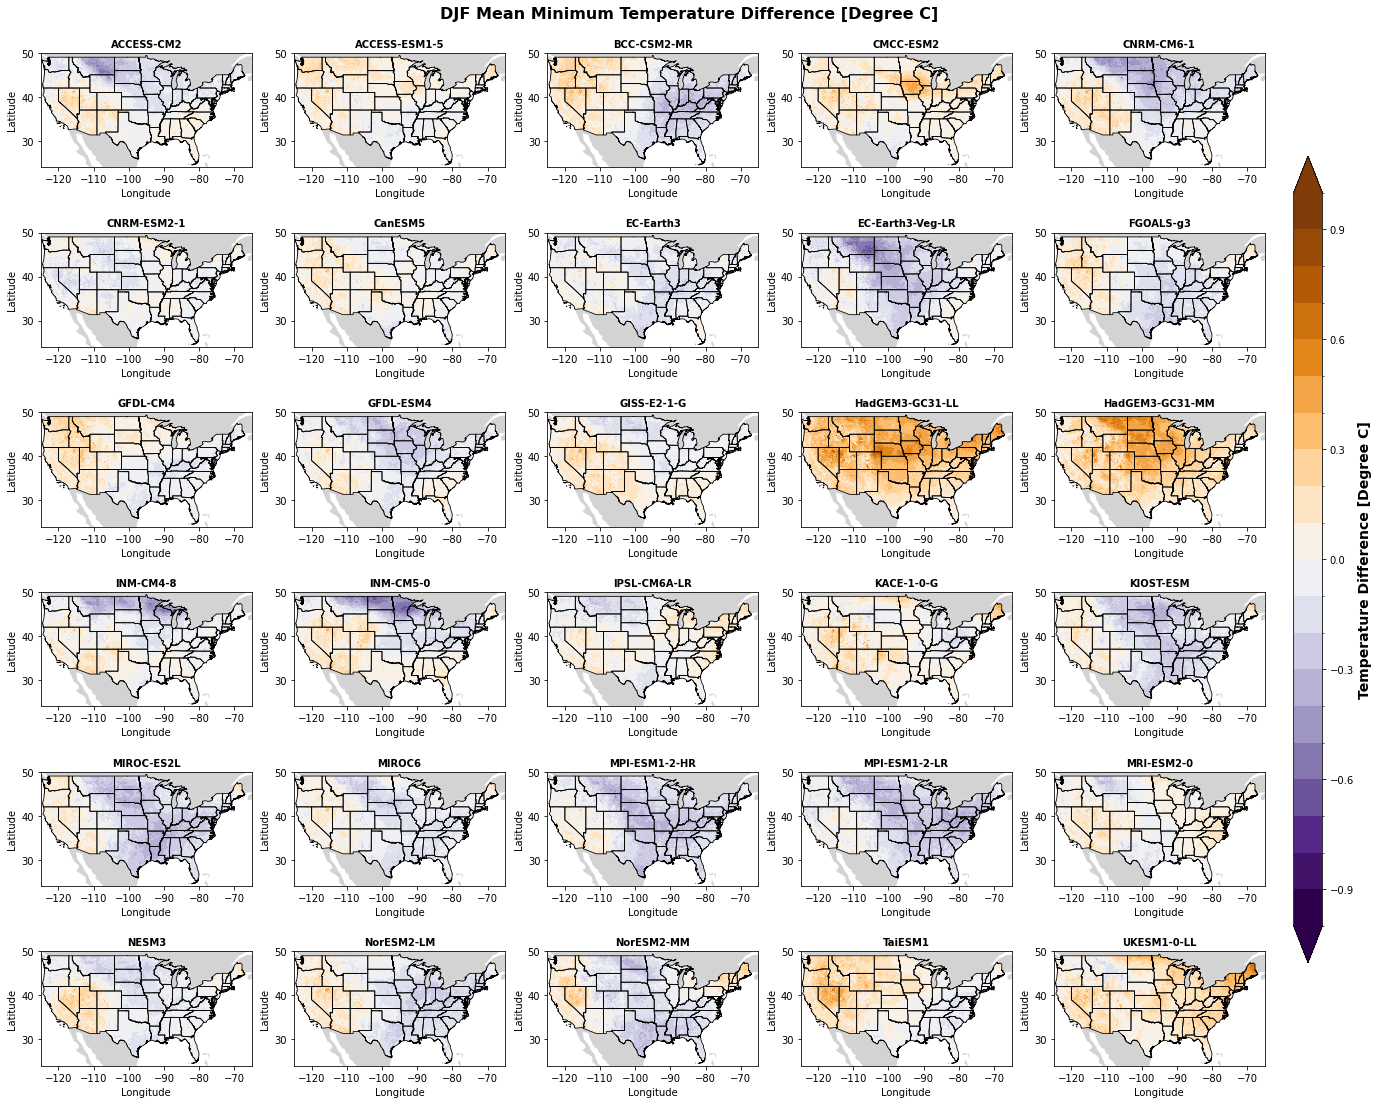

In [4]:
import glob
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load models
models = glob.glob("/nobackupp10/datapool/NEX-DCP30-CMIP6/*")
models.sort()
var = "tasmin"

# Set up the figure and axes
fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(20, 16), subplot_kw={'projection': None})

# Load geographic data
usa_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
states = gpd.read_file("conus.geojson")

# Custom colormap and normalization
# cmap_diff = plt.get_cmap('coolwarm')  # Example colormap, you may need to adjust
# bounds_diff = mcolors.Normalize(vmin=-5, vmax=1)  # Adjust these values as needed
# intervals = 11  # Number of intervals, adjust as needed

# Iterate through models and plot each one in a subplot
# Iterate through models and plot each one in a subplot
for i, model in enumerate(models):
    print(model)
    row = i // 5
    col = i % 5
    ax = axs[row, col]

    DCP = xr.open_zarr(f"/nobackupp10/skhajehe/dcp-indices/multimodel/single/tasmin/{model.split('/')[-1]}_seasonal.zarr")
    PRISM = xr.open_zarr(f"/nobackupp10/skhajehe/dcp-indices/prism/seasonal_average/{var}/2014.zarr")
    PRISM = PRISM.where(DCP[var].notnull())
    DCP['lon'] = (DCP['lon'] + 180) % 360 - 180
    DCP = DCP.sortby(DCP.lon)
    PRISM['lon'] = (PRISM['lon'] + 180) % 360 - 180
    PRISM = PRISM.sortby(PRISM.lon)
    DCP.load()
    PRISM.load()

    usa_states[usa_states['continent'] == 'North America'].plot(ax=ax, edgecolor='none', facecolor='lightgrey', linewidth=0.8)

    plot = (DCP-PRISM).tasmin.sel(season="DJF").plot(ax=ax, cmap=cmap_diff, norm=bounds_diff, levels=intervals_diff, add_colorbar=False)

    states.boundary.plot(ax=ax, linewidth=0.8, color='black')
    ax.set_xlim(-125, -65)
    ax.set_ylim(24, 50)
    ax.set_title(model.split("/")[-1], fontsize=10,fontweight='bold')
    ax.set_xlabel("Longitude", fontsize=10)
    ax.set_ylabel("Latitude", fontsize=10)
# Add the single colorbar on the right side of the figure
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(plot, cax=cax, orientation='vertical', extend='both')
cbar.set_label('Temperature Difference [Degree C]', fontweight='bold', fontsize=14)

# Adjust layout and save the figure
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.2, hspace=0.3)
plt.suptitle('DJF Mean Minimum Temperature Difference [Degree C]', fontweight='bold', fontsize=16)
plt.savefig("./plot/all_min_DJF_diff.png", dpi=300)
plt.show()

In [3]:
## import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define color intervals and corresponding colors
intervals = np.arange(-6, 18, 2)
colors = plt.cm.RdYlBu_r(np.linspace(0, 1, len(intervals) - 1))  # Use YlOrRd colormap

# Create a custom colormap with specified intervals and colors
cmap = mcolors.ListedColormap(colors)
bounds = mcolors.BoundaryNorm(intervals, cmap.N)


In [23]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define color intervals and corresponding colors
intervals_diff= np.arange(-0.5, 0.55, 0.05)
colors_diff= plt.cm.RdBu_r(np.linspace(0, 1, len(intervals_diff) - 1))  # Use YlOrRd colormap

# Create a custom colormap with specified intervals and colors
cmap_diff= mcolors.ListedColormap(colors_diff)
bounds_diff= mcolors.BoundaryNorm(intervals_diff, cmap_diff.N)




In [17]:
!ls /nobackupp10/skhajehe/dcp-indices/prism/seasonal_average/tasmin

2014.zarr


In [ ]:
models=glob.glob("/nobackupp10/datapool/NEX-DCP30-CMIP6/*")
models.sort()
var="tasmin"
for model in models:
    DCP=xr.open_zarr("/nobackupp10/skhajehe/dcp-indices/multimodel/quantile/"+var+"/"+model.split("/")[-1]+".zarr")
    # PRISM=xr.open_zarr("/nobackupp10/skhajehe/dcp-indices/prism/seasonal_average/"+var+"/2014.zarr")
    # PRISM=PRISM.where(DCP[var].notnull())
    DCP['lon'] = (DCP['lon'] + 180) % 360 - 180
    DCP = DCP.sortby(DCP.lon)
    # PRISM['lon'] = (PRISM['lon'] + 180) % 360 - 180
    # PRISM = PRISM.sortby(PRISM.lon)
    DCP.load()
    # PRISM.load()
    fig, ax = plt.subplots(figsize=(12, 12))
    usa_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    usa_states[usa_states['continent'] == 'North America'].plot(ax=ax, edgecolor='none', facecolor='lightgrey', linewidth=0.8)
    # cmap = mcolors.TwoSlopeNorm(vmin=-10, vcenter=0, vmax=20)

    plot = DCP.tasmin.sel(quantile=0.9).plot(ax=ax,cmap=cmap, norm=bounds,levels=intervals, extend='both' ,add_colorbar=False)
    # Add state boundaries
    states = gpd.read_file("conus.geojson")
    states.boundary.plot(ax=ax, linewidth=0.8, color='black')
    # Setting x and y axis limits
    ax.set_xlim(-125, -65)  # Example values, adjust according to your data
    ax.set_ylim(24, 50)  # Example values, adjust according to your data

    plt.title(model.split("/")[-1]+" 90th Percentile Min Temperature [Degree C]", fontweight='bold',fontsize=16)
    plt.xlabel("Longitude", fontsize=16)
    plt.ylabel("Latitude", fontsize=16)

    cax = fig.add_axes([0.92, 0.285, 0.02, 0.440])  # [left, bottom, width, height]
    cbar = plt.colorbar(plot, cax=cax, orientation='vertical',extendfrac='auto')
    cbar.set_label('Temperature [Degree C]',fontweight='bold', fontsize=14)
    cbar.ax.yaxis.set_tick_params(labelsize='large')
    # plt.show()
    plt.savefig("./plots/"+model.split("/")[-1]+"_min_temp_0.9.png")

    
#     fig, ax = plt.subplots(figsize=(12, 12))
#     usa_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#     usa_states[usa_states['continent'] == 'North America'].plot(ax=ax, edgecolor='none', facecolor='lightgrey', linewidth=0.8)
#     # cmap = mcolors.TwoSlopeNorm(vmin=-5, vcenter=0, vmax=1)

#     plot = (DCP-PRISM).tasmax.sel(season="JJA").plot(ax=ax,cmap=cmap_diff, norm=bounds_diff,levels=intervals, extend='both' , add_colorbar=False)
#     # Add state boundaries
#     states = gpd.read_file("conus.geojson")
#     states.boundary.plot(ax=ax, linewidth=0.8, color='black')
#     # Setting x and y axis limits
#     ax.set_xlim(-125, -65)  # Example values, adjust according to your data
#     ax.set_ylim(24, 50)  # Example values, adjust according to your data

#     plt.title(model.split("/")[-1]+" Maximum Temperature Difference [Degree C]", fontweight='bold',fontsize=16)
#     plt.xlabel("Longitude", fontsize=16)
#     plt.ylabel("Latitude", fontsize=16)

#     cax = fig.add_axes([0.92, 0.285, 0.02, 0.440])  # [left, bottom, width, height]
#     cbar = plt.colorbar(plot, cax=cax, orientation='vertical',extendfrac='auto')
#     cbar.set_label('Temperature Difference [Degree C]',fontweight='bold', fontsize=14)
#     plt.savefig("./plot/"+model.split("/")[-1]+"_max_temp_diff_JJA.png")

    

In [3]:
models=glob.glob("/nobackupp10/datapool/NEX-DCP30-CMIP6/*")
models.sort()
models

['/nobackupp10/datapool/NEX-DCP30-CMIP6/ACCESS-CM2',
 '/nobackupp10/datapool/NEX-DCP30-CMIP6/ACCESS-ESM1-5',
 '/nobackupp10/datapool/NEX-DCP30-CMIP6/BCC-CSM2-MR',
 '/nobackupp10/datapool/NEX-DCP30-CMIP6/CMCC-ESM2',
 '/nobackupp10/datapool/NEX-DCP30-CMIP6/CNRM-CM6-1',
 '/nobackupp10/datapool/NEX-DCP30-CMIP6/CNRM-ESM2-1',
 '/nobackupp10/datapool/NEX-DCP30-CMIP6/CanESM5',
 '/nobackupp10/datapool/NEX-DCP30-CMIP6/EC-Earth3',
 '/nobackupp10/datapool/NEX-DCP30-CMIP6/EC-Earth3-Veg-LR',
 '/nobackupp10/datapool/NEX-DCP30-CMIP6/FGOALS-g3',
 '/nobackupp10/datapool/NEX-DCP30-CMIP6/GFDL-CM4',
 '/nobackupp10/datapool/NEX-DCP30-CMIP6/GFDL-ESM4',
 '/nobackupp10/datapool/NEX-DCP30-CMIP6/GISS-E2-1-G',
 '/nobackupp10/datapool/NEX-DCP30-CMIP6/HadGEM3-GC31-LL',
 '/nobackupp10/datapool/NEX-DCP30-CMIP6/HadGEM3-GC31-MM',
 '/nobackupp10/datapool/NEX-DCP30-CMIP6/INM-CM4-8',
 '/nobackupp10/datapool/NEX-DCP30-CMIP6/INM-CM5-0',
 '/nobackupp10/datapool/NEX-DCP30-CMIP6/IPSL-CM6A-LR',
 '/nobackupp10/datapool/NEX-DCP30

In [6]:
DCP=xr.open_zarr("/nobackupp10/skhajehe/dcp-indices/multimodel/single/tasmin/HadGEM3-GC31-LL_seasonal.zarr")
PRISM=xr.open_zarr("/nobackupp10/skhajehe/dcp-indices/prism/seasonal_average/tasmin/2014.zarr")
PRISM=PRISM.where(DCP["tasmin"].notnull())
DCP['lon'] = (DCP['lon'] + 180) % 360 - 180
DCP = DCP.sortby(DCP.lon)
PRISM['lon'] = (PRISM['lon'] + 180) % 360 - 180
PRISM = PRISM.sortby(PRISM.lon)
DCP.load()
PRISM.load()

<xarray.Dataset> Size: 349MB
Dimensions:  (season: 4, lat: 3105, lon: 7025)
Coordinates:
  * lat      (lat) float64 25kB 24.07 24.08 24.08 24.09 ... 49.92 49.93 49.93
  * lon      (lon) float64 56kB -125.0 -125.0 -125.0 ... -66.5 -66.49 -66.48
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    tasmin   (season, lat, lon) float32 349MB nan nan nan nan ... nan nan nan

In [7]:
(DCP-PRISM).tasmin.sel(season="DJF").max()

<xarray.DataArray 'tasmin' ()> Size: 4B
array(0.807045, dtype=float32)
Coordinates:
    season   <U3 12B 'DJF'